In [2]:
import os
import inspect
import csv as csv
import re
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import _tree, DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import mutual_info_regression, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report
)
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

from category_encoders import TargetEncoder






In [3]:
df = pd.read_csv('pca2.csv')
df.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE
0,2023000000009,1,3600,19,1,19,2,16,1,7220,8,2,8680,4055,3,3,0
1,2023000000028,1,800,23,1,19,1,15,1,7115,1,1,8564,2850,3,3,1
2,2023000000052,1,1800,23,1,20,1,15,1,7115,1,1,8564,2850,3,3,1
3,2023000000125,1,65000,28,1,19,1,40,6,4492,9,2,4796,4760,3,3,0
4,2023000000152,1,3000,20,1,19,2,20,6,61101,2,1,7870,4640,3,3,2


# Bin Wage And Predict Ranges

In [4]:
from xgboost import XGBClassifier
df["WAGP_log"] = np.log(df['WAGP'])
df['wage_bin'] = (df['WAGP_log'] // 10).astype(int)
X = df.drop(columns = ['WAGP', 'wage_bin', 'WAGP_log'])
y = df['wage_bin']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train classifier (XGBoost works great with tabular data)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [20:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71      8783
           1       0.90      0.95      0.92     28492

    accuracy                           0.88     37275
   macro avg       0.85      0.80      0.82     37275
weighted avg       0.87      0.88      0.87     37275

Confusion Matrix:
 [[ 5688  3095]
 [ 1482 27010]]


# log wage ranges

In [5]:
print(f"Max log wage: {df['WAGP_log'].max()}")
print(f"Min log wage: {df['WAGP_log'].min()}")
print(f"Avg log wage: {np.mean(df['WAGP_log'])}")

Max log wage: 12.950388112664518
Min log wage: 1.3862943611198906
Avg log wage: 10.614789233575465


## Classification report

C:\Users\rohan\AppData\Local\Temp\ipykernel_12236\1523181738.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = class_metrics.index, y = class_metrics['f1-score'], palette = 'viridis')


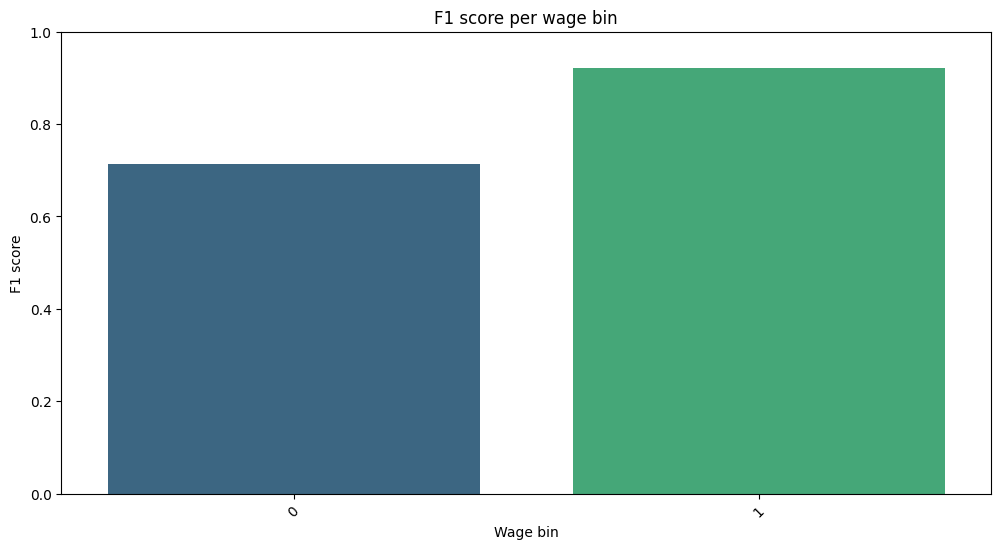

In [6]:
report = classification_report(y_test, y_pred, output_dict= True)
report_df = pd.DataFrame(report).transpose()
class_metrics = report_df.iloc[:-3]

plt.figure(figsize = (12,6))
sns.barplot(x = class_metrics.index, y = class_metrics['f1-score'], palette = 'viridis')
plt.ylabel("F1 score")
plt.xlabel("Wage bin")
plt.title("F1 score per wage bin")
plt.xticks(rotation = 45)
plt.ylim(0,1)
plt.show()

## Wage bin distribution

<Axes: title={'center': 'Wage Bin Distribution'}>

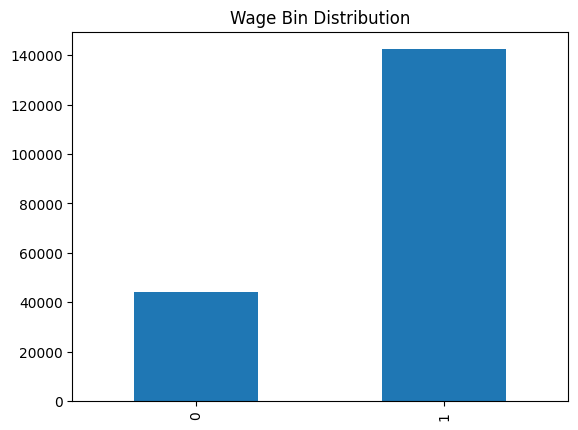

In [7]:
df['wage_bin'].value_counts().sort_index().plot(kind='bar', title='Wage Bin Distribution')


# Wage Prediction With More Bins

In [8]:
from xgboost import XGBClassifier
df["WAGP_log"] = np.log(df['WAGP'])
df['wage_bin'] = (df['WAGP_log'] // 1.5).astype(int)
X = df.drop(columns = ['WAGP', 'wage_bin', 'WAGP_log'])
y = df['wage_bin']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train classifier 
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Wage bins: {df['wage_bin'].unique()}")

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [20:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.25      0.50      0.33         2
           2       1.00      0.26      0.41        35
           3       0.51      0.17      0.25       168
           4       0.45      0.16      0.24       677
           5       0.52      0.33      0.41      2756
           6       0.64      0.63      0.63     10869
           7       0.74      0.85      0.79     19559
           8       0.63      0.39      0.48      3208

    accuracy                           0.69     37275
   macro avg       0.53      0.37      0.39     37275
weighted avg       0.68      0.69      0.68     37275

Confusion Matrix:
 [[    0     0     0     0     0     1     0     0     0]
 [    0     1     0     0     0     0     1     0     0]
 [    0     1     9     4     3    11     7     0     0]
 [    0     1     0    28    25    64    44     6     0]
 [    0     0     0     

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

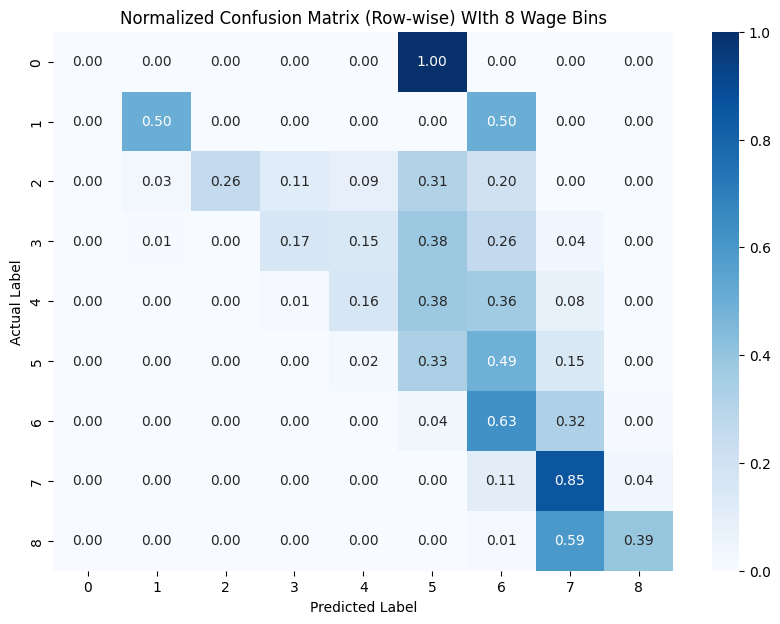

In [9]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
# Normalize by row (i.e., by the total actual counts per class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Normalized Confusion Matrix (Row-wise) WIth 8 Wage Bins")
plt.show()


## Classification Report

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

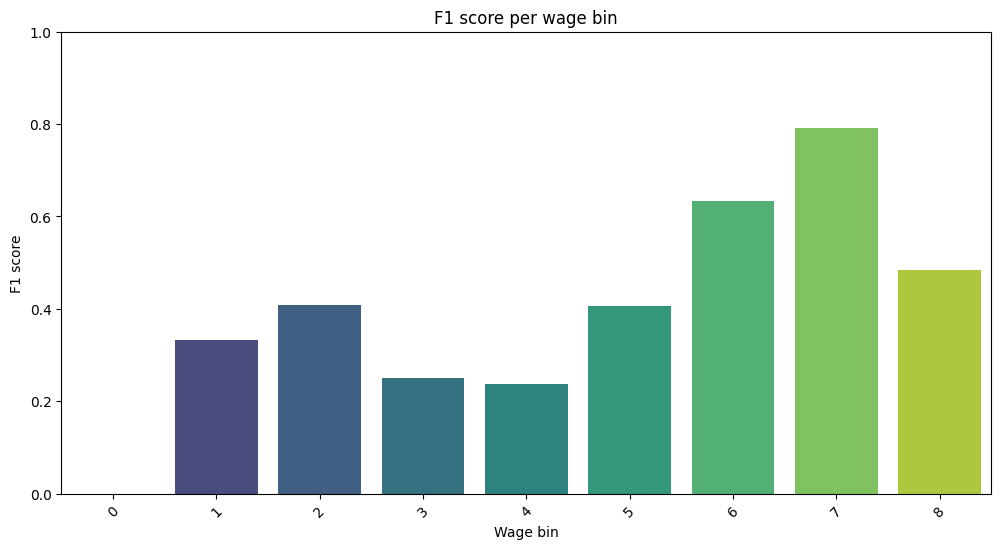

In [10]:
report = classification_report(y_test, y_pred, output_dict= True)
report_df = pd.DataFrame(report).transpose()
class_metrics = report_df.iloc[:-3]

plt.figure(figsize = (12,6))
sns.barplot(x = class_metrics.index, y = class_metrics['f1-score'], palette = 'viridis')
plt.ylabel("F1 score")
plt.xlabel("Wage bin")
plt.title("F1 score per wage bin")
plt.xticks(rotation = 45)
plt.ylim(0,1)
plt.show()

## Wage Bin Distribution, Shows Reason for Skeweness

<Axes: title={'center': 'Wage Bin Distribution'}>

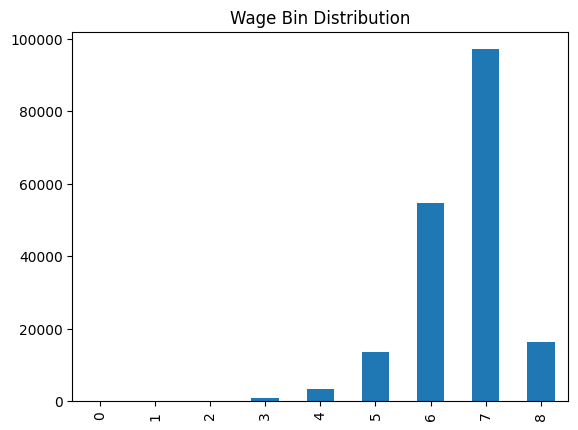

In [11]:
df['wage_bin'].value_counts().sort_index().plot(kind='bar', title='Wage Bin Distribution')


# Tuning 8 Bin Model

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Wage bins: {df['wage_bin'].unique()}")

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [20:58:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       0.35      0.31      0.33        35
           3       0.26      0.27      0.26       168
           4       0.25      0.29      0.27       677
           5       0.43      0.37      0.40      2756
           6       0.64      0.61      0.62     10869
           7       0.76      0.75      0.76     19559
           8       0.46      0.62      0.53      3208

    accuracy                           0.66     37275
   macro avg       0.46      0.47      0.46     37275
weighted avg       0.66      0.66      0.66     37275

Confusion Matrix:
 [[    0     0     0     0     0     1     0     0     0]
 [    0     2     0     0     0     0     0     0     0]
 [    0     0    11     3     8     8     3     2     0]
 [    0     0     0    45    45    48    25     5     0]
 [    0     0     3    2

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction Capabilities

In [ ]:


df = df[df['WAGP'] > 0]  
df["WAGP_log"] = np.log(df['WAGP'])
df['wage_bin'] = (df['WAGP_log'] // 1.5).astype(int)

X = df.drop(columns = ['WAGP', 'wage_bin', 'WAGP_log'])
y = df['wage_bin']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Prediction
sample_idx = 0  
sample_input = X_test[sample_idx].reshape(1, -1)

predicted_bin = model.predict(sample_input)[0]

# Map bin back to wage range
log_wage_lower = predicted_bin * 1.5
log_wage_upper = (predicted_bin + 1) * 1.5
wage_range_lower = np.exp(log_wage_lower)
wage_range_upper = np.exp(log_wage_upper)

print(f"Predicted Wage Bin: {predicted_bin}")
print(f"Predicted Wage Range: ${wage_range_lower:.2f} - ${wage_range_upper:.2f}")

# Compare to actual
actual_bin = y_test.iloc[sample_idx]
print(f"Actual Wage Bin: {actual_bin}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [20:59:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predicted Wage Bin: 7
Predicted Wage Range: $36315.50 - $162754.79
Actual Wage Bin: 7
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         2
           2       0.35      0.31      0.33        35
           3       0.26      0.27      0.26       168
           4       0.25      0.29      0.27       677
           5       0.43      0.37      0.40      2756
           6       0.64      0.61      0.62     10869
           7       0.76      0.75      0.76     19559
           8       0.46      0.62      0.53      3208

    accuracy                           0.66     37275
   macro avg       0.46      0.47      0.46     37275
weighted avg       0.66      0.66      0.66     37275

Confusion Matrix:
 [[    0     0     0     0     0     1     0     0     0]
 [    0     2     0     0     0     0     0     0     0]
 [    0     0    11     3     8     8     3     2   

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


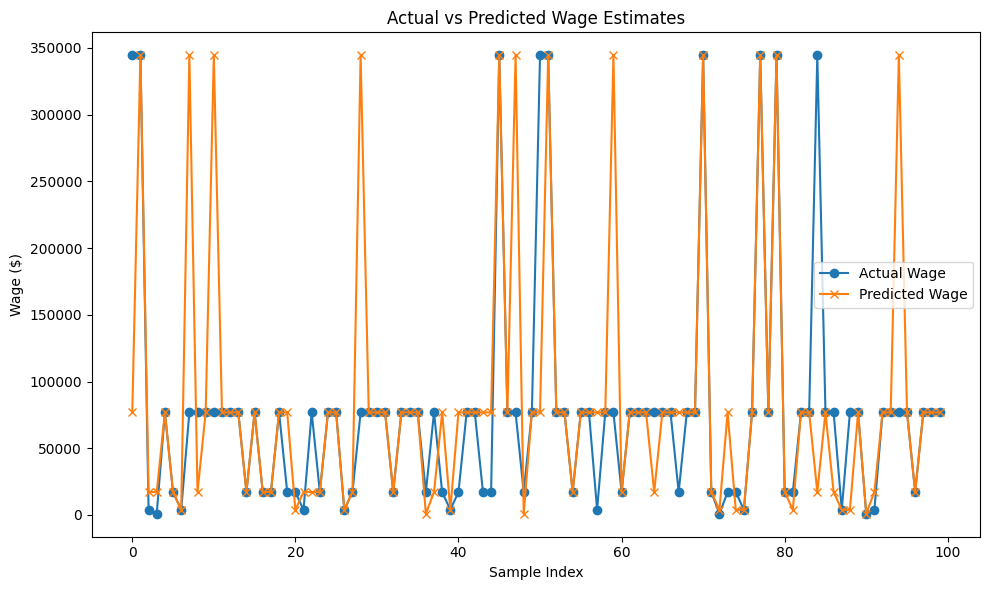

In [14]:
# Function to convert bin to wage range midpoint
def bin_to_wage(bin_val):
    log_mid = (bin_val + 0.5) * 1.5
    return np.exp(log_mid)

sample_df = pd.DataFrame({
    'Actual Bin': y_test,
    'Predicted Bin': y_pred
}).sample(100)

sample_df['Actual Wage ($)'] = sample_df['Actual Bin'].apply(bin_to_wage)
sample_df['Predicted Wage ($)'] = sample_df['Predicted Bin'].apply(bin_to_wage)

plt.figure(figsize=(10, 6))
plt.plot(sample_df['Actual Wage ($)'].values, label='Actual Wage', marker='o')
plt.plot(sample_df['Predicted Wage ($)'].values, label='Predicted Wage', marker='x')
plt.title('Actual vs Predicted Wage Estimates')
plt.xlabel('Sample Index')
plt.ylabel('Wage ($)')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


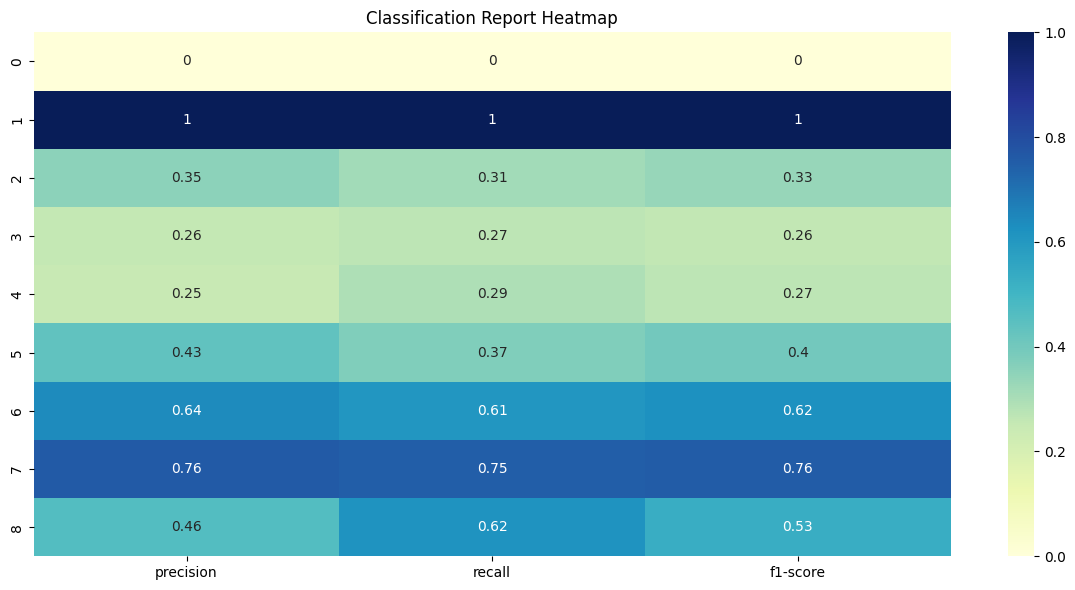

In [15]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-3]  # Remove avg rows

plt.figure(figsize=(12, 6))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.tight_layout()
plt.show()


In [16]:

class_labels = model.classes_  

probs_df = pd.DataFrame(probs, columns=[f'Class {cls}' for cls in class_labels])

# add predicted class per row
probs_df['Predicted Class'] = np.argmax(probs, axis=1)

# Round probabilities for cleaner view
probs_df_rounded = probs_df.round(3)
print("Probabilities of Each Class")
print(probs_df_rounded.head(15))


NameError: name 'probs' is not defined

# Final Model

In [ ]:
from xgboost import XGBClassifier
df["WAGP_log"] = np.log(df['WAGP'])
df['wage_bin'] = (df['WAGP_log'] // 1.53).astype(int)
X = df.drop(columns = ['WAGP', 'wage_bin', 'WAGP_log', 'SERIALNO', 'SPORDER'])
y = df['wage_bin']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train classifier 
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

sample_idx = 0  
sample_input = X_test[sample_idx].reshape(1, -1)

predicted_bin = model.predict(sample_input)[0]

# Map bin back to wage range
log_wage_lower = predicted_bin * 1.5
log_wage_upper = (predicted_bin + 1) * 1.5
wage_range_lower = np.exp(log_wage_lower)
wage_range_upper = np.exp(log_wage_upper)

print(f"Number of bins: {df['wage_bin'].unique()}")
print(f"Predicted Wage Bin: {predicted_bin}")
print(f"Predicted Wage Range: ${wage_range_lower:.2f} - ${wage_range_upper:.2f}")

# Compare to actual
actual_bin = y_test.iloc[sample_idx]
print(f"Actual Wage Bin: {actual_bin}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [20:59:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Number of bins: [5 4 7 6 3 1 8 2 0]
Predicted Wage Bin: 7
Predicted Wage Range: $36315.50 - $162754.79
Actual Wage Bin: 7
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      0.50      0.40         2
           2       1.00      0.29      0.44        35
           3       0.49      0.19      0.27       176
           4       0.46      0.23      0.30       895
           5       0.51      0.31      0.38      2904
           6       0.68      0.70      0.69     13089
           7       0.75      0.85      0.80     18506
           8       0.59      0.19      0.29      1667

    accuracy                           0.71     37275
   macro avg       0.53      0.36      0.40     37275
weighted avg       0.69      0.71      0.69     37275

Confusion Matrix:
 [[    0     0     0     0     0     1     0     0     0]
 [    0     1     0     0     0     0     1     0     0]
 [    0     1   

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


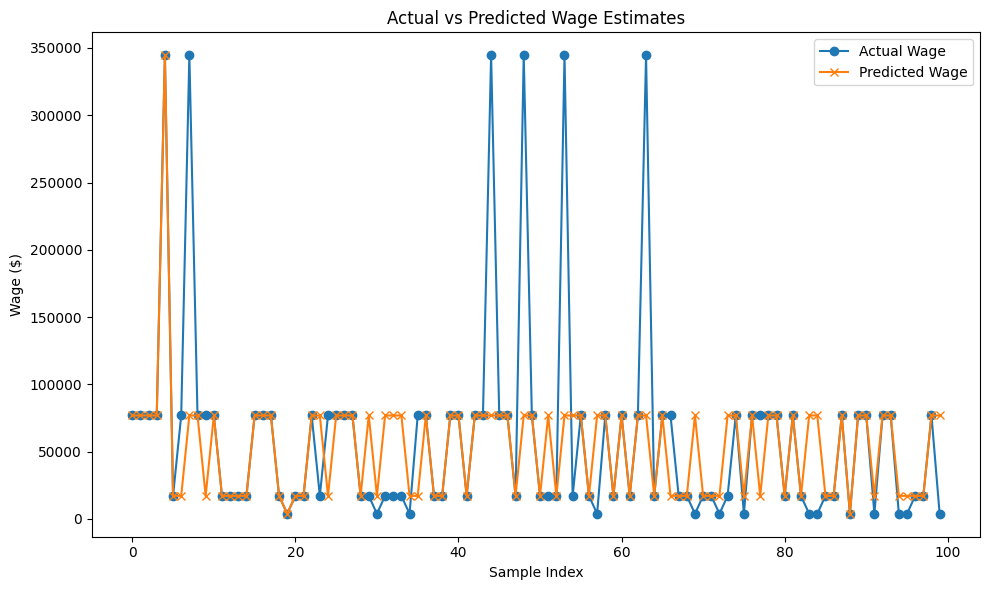

In [18]:
# Function to convert bin to wage range midpoint
def bin_to_wage(bin_val):
    log_mid = (bin_val + 0.5) * 1.5
    return np.exp(log_mid)

sample_df = pd.DataFrame({
    'Actual Bin': y_test,
    'Predicted Bin': y_pred
}).sample(100)

sample_df['Actual Wage ($)'] = sample_df['Actual Bin'].apply(bin_to_wage)
sample_df['Predicted Wage ($)'] = sample_df['Predicted Bin'].apply(bin_to_wage)

plt.figure(figsize=(10, 6))
plt.plot(sample_df['Actual Wage ($)'].values, label='Actual Wage', marker='o')
plt.plot(sample_df['Predicted Wage ($)'].values, label='Predicted Wage', marker='x')
plt.title('Actual vs Predicted Wage Estimates')
plt.xlabel('Sample Index')
plt.ylabel('Wage ($)')
plt.legend()
plt.tight_layout()
plt.show()


### The model struggles with predicting outliers. Should find means of further standardizing target feature wage or potentially remove/replace outliers

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


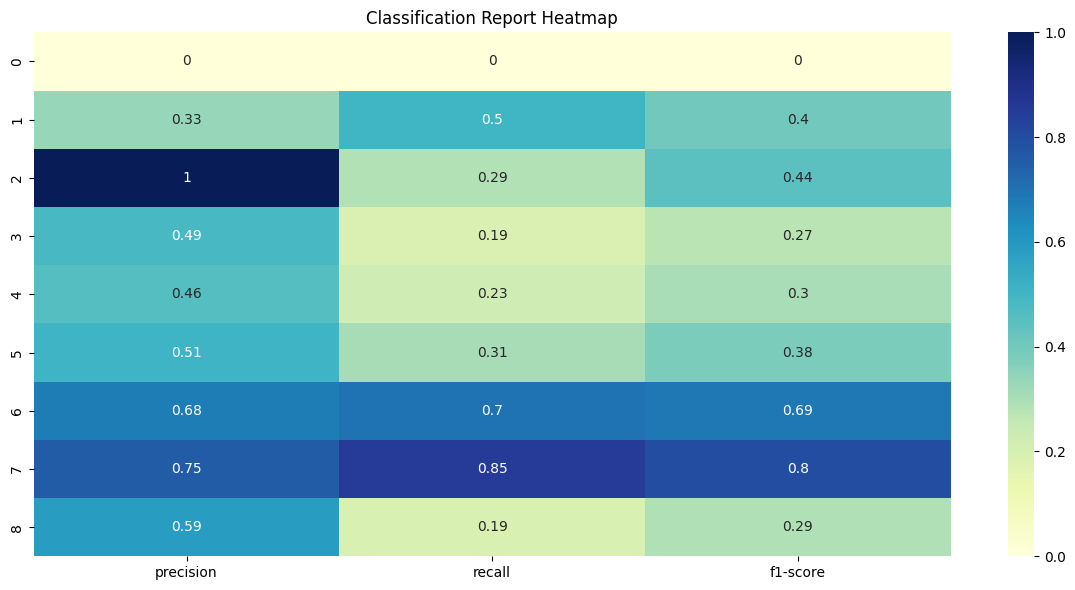

In [19]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-3]  # Remove avg rows

plt.figure(figsize=(12, 6))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.tight_layout()
plt.show()


### Further supports the need for outlier handling

## Normalized Confusion Matrix

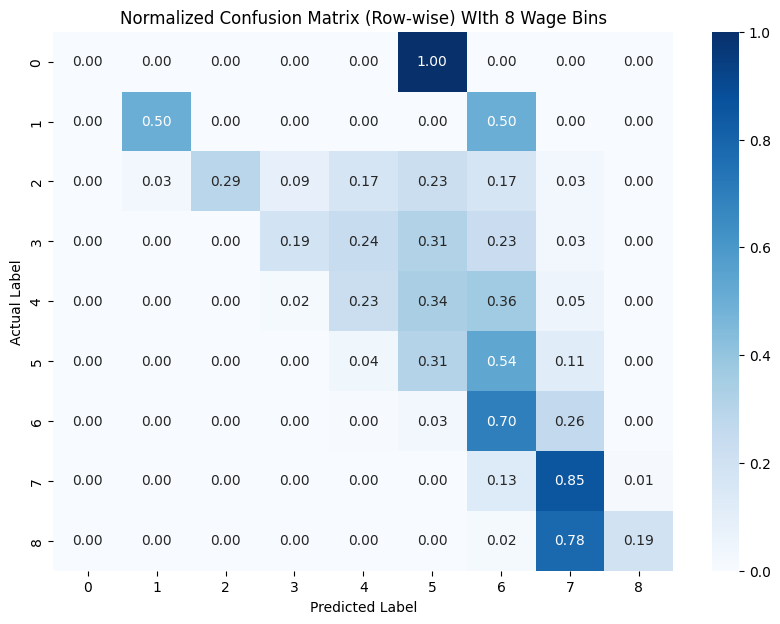

In [20]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
# Normalize by row (i.e., by the total actual counts per class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Normalized Confusion Matrix (Row-wise) WIth 8 Wage Bins")
plt.show()


### Labels to note: 0 (all predicted as 5), 2 and 3 (both of these labels have very low prediction accuracies)

In [21]:

from xgboost import XGBClassifier
df["WAGP_log"] = np.log(df['WAGP'])
df['wage_bin'] = pd.qcut(df['WAGP'], q=9, labels=False)  # 9 bins, equally populated
X = df.drop(columns = ['WAGP', 'wage_bin', 'WAGP_log', 'SERIALNO', 'SPORDER'])
y = df['wage_bin']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train classifier 
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

sample_idx = 0  # You can pick any index
sample_input = X_test[sample_idx].reshape(1, -1)

predicted_bin = model.predict(sample_input)[0]

# Map bin back to wage range
log_wage_lower = predicted_bin * 1.5
log_wage_upper = (predicted_bin + 1) * 1.5
wage_range_lower = np.exp(log_wage_lower)
wage_range_upper = np.exp(log_wage_upper)

print(f"Number of bins: {df['wage_bin'].unique()}")
print(f"Predicted Wage Bin: {predicted_bin}")
print(f"Predicted Wage Range: ${wage_range_lower:.2f} - ${wage_range_upper:.2f}")

# Compare to actual
actual_bin = y_test.iloc[sample_idx]
print(f"Actual Wage Bin: {actual_bin}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [21:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Number of bins: [0 5 1 8 4 3 2 6 7]
Predicted Wage Bin: 6
Predicted Wage Range: $8103.08 - $36315.50
Actual Wage Bin: 6
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.62      0.61      4537
           1       0.39      0.32      0.35      3797
           2       0.34      0.32      0.33      4073
           3       0.31      0.36      0.33      4345
           4       0.27      0.18      0.21      3957
           5       0.28      0.28      0.28      4565
           6       0.29      0.29      0.29      4420
           7       0.34      0.35      0.35      3985
           8       0.50      0.65      0.57      3596

    accuracy                           0.37     37275
   macro avg       0.37      0.37      0.37     37275
weighted avg       0.37      0.37      0.37     37275

Confusion Matrix:
 [[2825  711  358  229   80  124  100   61   49]
 [ 939 1231  705  415  136  161  101   56   53]
 [ 387  599 1316  958  245  281  143

In [23]:
from sklearn.calibration import CalibratedClassifierCV

cal_model = CalibratedClassifierCV(model, cv=3)
cal_model.fit(X_train, y_train)


C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [21:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [21:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [21:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

CalibratedClassifierCV(cv=3,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='mlogloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               objective='multi:softprob', ...))